# Using the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class
This is a tutorial for using the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class.  

Like the [session](https://pbjam.readthedocs.io/en/latest/jar.html#pbjam.jar.session) class, the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class is a wrapper for much of the functionality in PBjam. The [session](https://pbjam.readthedocs.io/en/latest/jar.html#pbjam.jar.session) class actually just creates a list of [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class instances and loops over this list during the peakbagging process.

The star class is useful if you want a bit more control over, e.g., the light curve reduction and power spectrum computation. 

## Preparing the data
The [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class takes [lightkurve.periodogram]() objects as data input, while the remaining parameters are identical to those for [session](https://pbjam.readthedocs.io/en/latest/jar.html#pbjam.jar.session) (although lists are not allowed here). 

Let's create a [Lightkurve lightcurve](https://docs.lightkurve.org/api/lightkurve.lightcurve.LightCurve.html) object and then compute the periodogram. We'll start with just downloading Q1 data for KIC4448777, and using the PDCSAP_FLUX.

In [1]:
import lightkurve as lk
lc = lk.search_lightcurvefile('KIC4448777', quarter=1).download().PDCSAP_FLUX

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


While the PDCSAP pipeline does a pretty good job in preparing light curves for asteroseismology, we might want to perform some manipulation of the data. Since we're using [Lightkurve](https://docs.lightkurve.org/), for the purposes of this exercise we'll just use some of the built-in functions.

In [ ]:
def reduce_timeseries(lc):
    return lc.normalize().flatten(window_length=401)

lc0 = reduce_timeseris(lc)

Next lets add a few more quarters of data to the timeseries

In [ ]:
for q in range(2,17):
    lc = lk.search_lightcurvefile('KIC4448777', quarter=q).download().PDCSAP_FLUX
    
    lc = reduce_timeseries(lc)
    
    lc0 = lc.append(lc)
    
lc0 = lc0.remove_outliers(4)

We can have a quick look at the time series to check that everything looks good

In [ ]:
lc0.plot()

Now lets compute the power density spectrum

In [3]:
pg = lc.to_periodogram(normalization='psd')

/Users/davies/Library/Python/3.6/lib/python/site-packages/lightkurve/periodogram.py:752: LightkurveWarning: Input light curve will be normalized.
  LightkurveWarning)


The functions in PBjam work best if you are using the SNR spectrum. That is, the powerspectrum with the background noise level divided out. Again, this can be done manually, but lightkurve as a built-in function for this too, so for the purposes of this tutorial we'll just use that.

In [ ]:
pg = pg.flatten()

Again, lets just have a quick look to make sure the power spectrum looks good

In [ ]:
pg.plot()

## Alright, time to peakbag
We'll start by defining some of the physical parameters of the star we're looking at, in this case we downloaded the lightcurve for KIC4448777. 

**Note:** When calling the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class here we don't have actually have to use the KIC identifier as the ID, we can pick any name we want. Only [session](https://pbjam.readthedocs.io/en/latest/jar.html#pbjam.jar.session) needs a proper identifier, since it uses [Lightkurve.search_lightcurvefile](https://docs.lightkurve.org/api/lightkurve.search.search_lightcurvefile.html).

In [ ]:
ID = 'catname'
numax = (220.0, 3.0)
dnu = (16.97, 0.05)
teff = (4750, 100)
bp_rp = (1.34, 0.1)

Now that we have a power spectrum we can initialize the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class instance. 

In [4]:
import pbjam as pb

st = pb.star(ID, pg, numax, dnu, teff, bp_rp, make_plots=True)

Like [session](https://pbjam.readthedocs.io/en/latest/jar.html#pbjam.jar.session), the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class has a 'to-it-all' functionality, which an be used by calling the class instance:

In [ ]:
st(norders = 7)

## A bit more step-by-step
In the following we'll show the different steps that PBjam takes when you ask it to 'do-it-all'. It's not a fully detailed explanation, with theory and everything, but should give you a bit more of a feel for the way PBjam is set up. For even more details, see the [Advanced notebook](https://pbjam.readthedocs.io/en/latest/example-advanced.html). 

The first step that PBjam takes is to estimate the phase term, $\epsilon$, in the p-mode asymptotic relation. This is often troublesome for stars with very broad modes (Bloody F-stars) where it's difficult to tell if you are looking at a $l=2,0$ pair or an $l=1$ mode. 

PBjam does this by finding the most likely value of $\epsilon$ based on the input parameters $\nu_{max}$, $\Delta \nu$, $T_{\mathrm{eff}}$, $B_p-R_p$, and a Gaussian kernel density estimate ([KDE](https://www.statsmodels.org/stable/generated/statsmodels.nonparametric.kernel_density.KDEMultivariate.html#statsmodels.nonparametric.kernel_density.KDEMultivariate)) of a large sample of values of these parameters collected from stars observed by *Kepler*.

This is done calling the [star.run_epsilon](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.run_epsilon) function.

In [5]:
st.run_epsilon()

The way we can evaluate the $\epsilon$ value that PBjam finds, is to plot where it thinks the $l=0$ modes are likely to be.

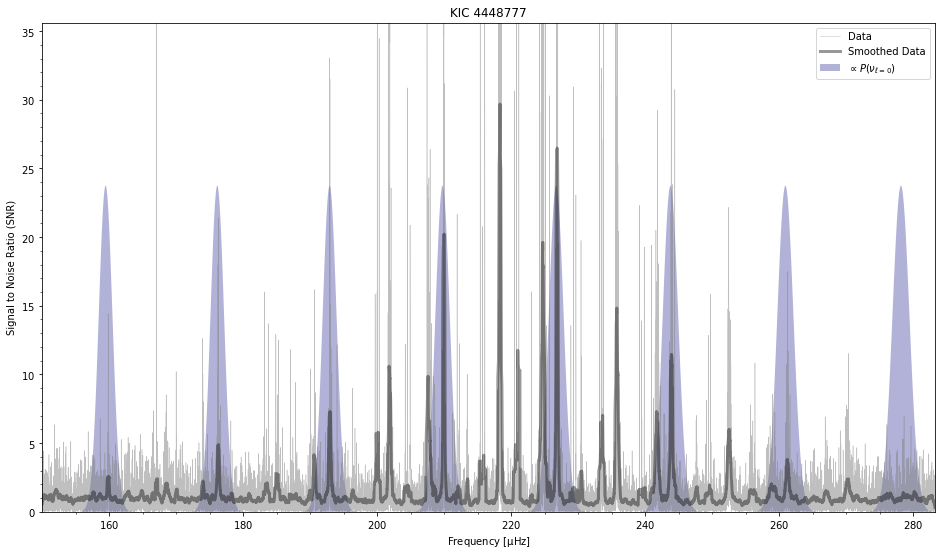

In [6]:
st.epsilon.plot(pg)

The purple distributoins indicate where PBjam thinks the $l=0$ modes are. At this point PBjam hasn't actually evaluated the power spectrum yet, it's only working based on the physical parameters we have given it, and the prior information for literature values. The result looks pretty good.

The next step is to fit asymptotic relation to the data, using the KDE as a prior. In this case we do this using the [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html) module, by calling [star.run_asy_peakbag](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.run_asy_peakbag)

In [7]:
st.run_asy_peakbag(norders=7)

The result can be examined using a corner plot:

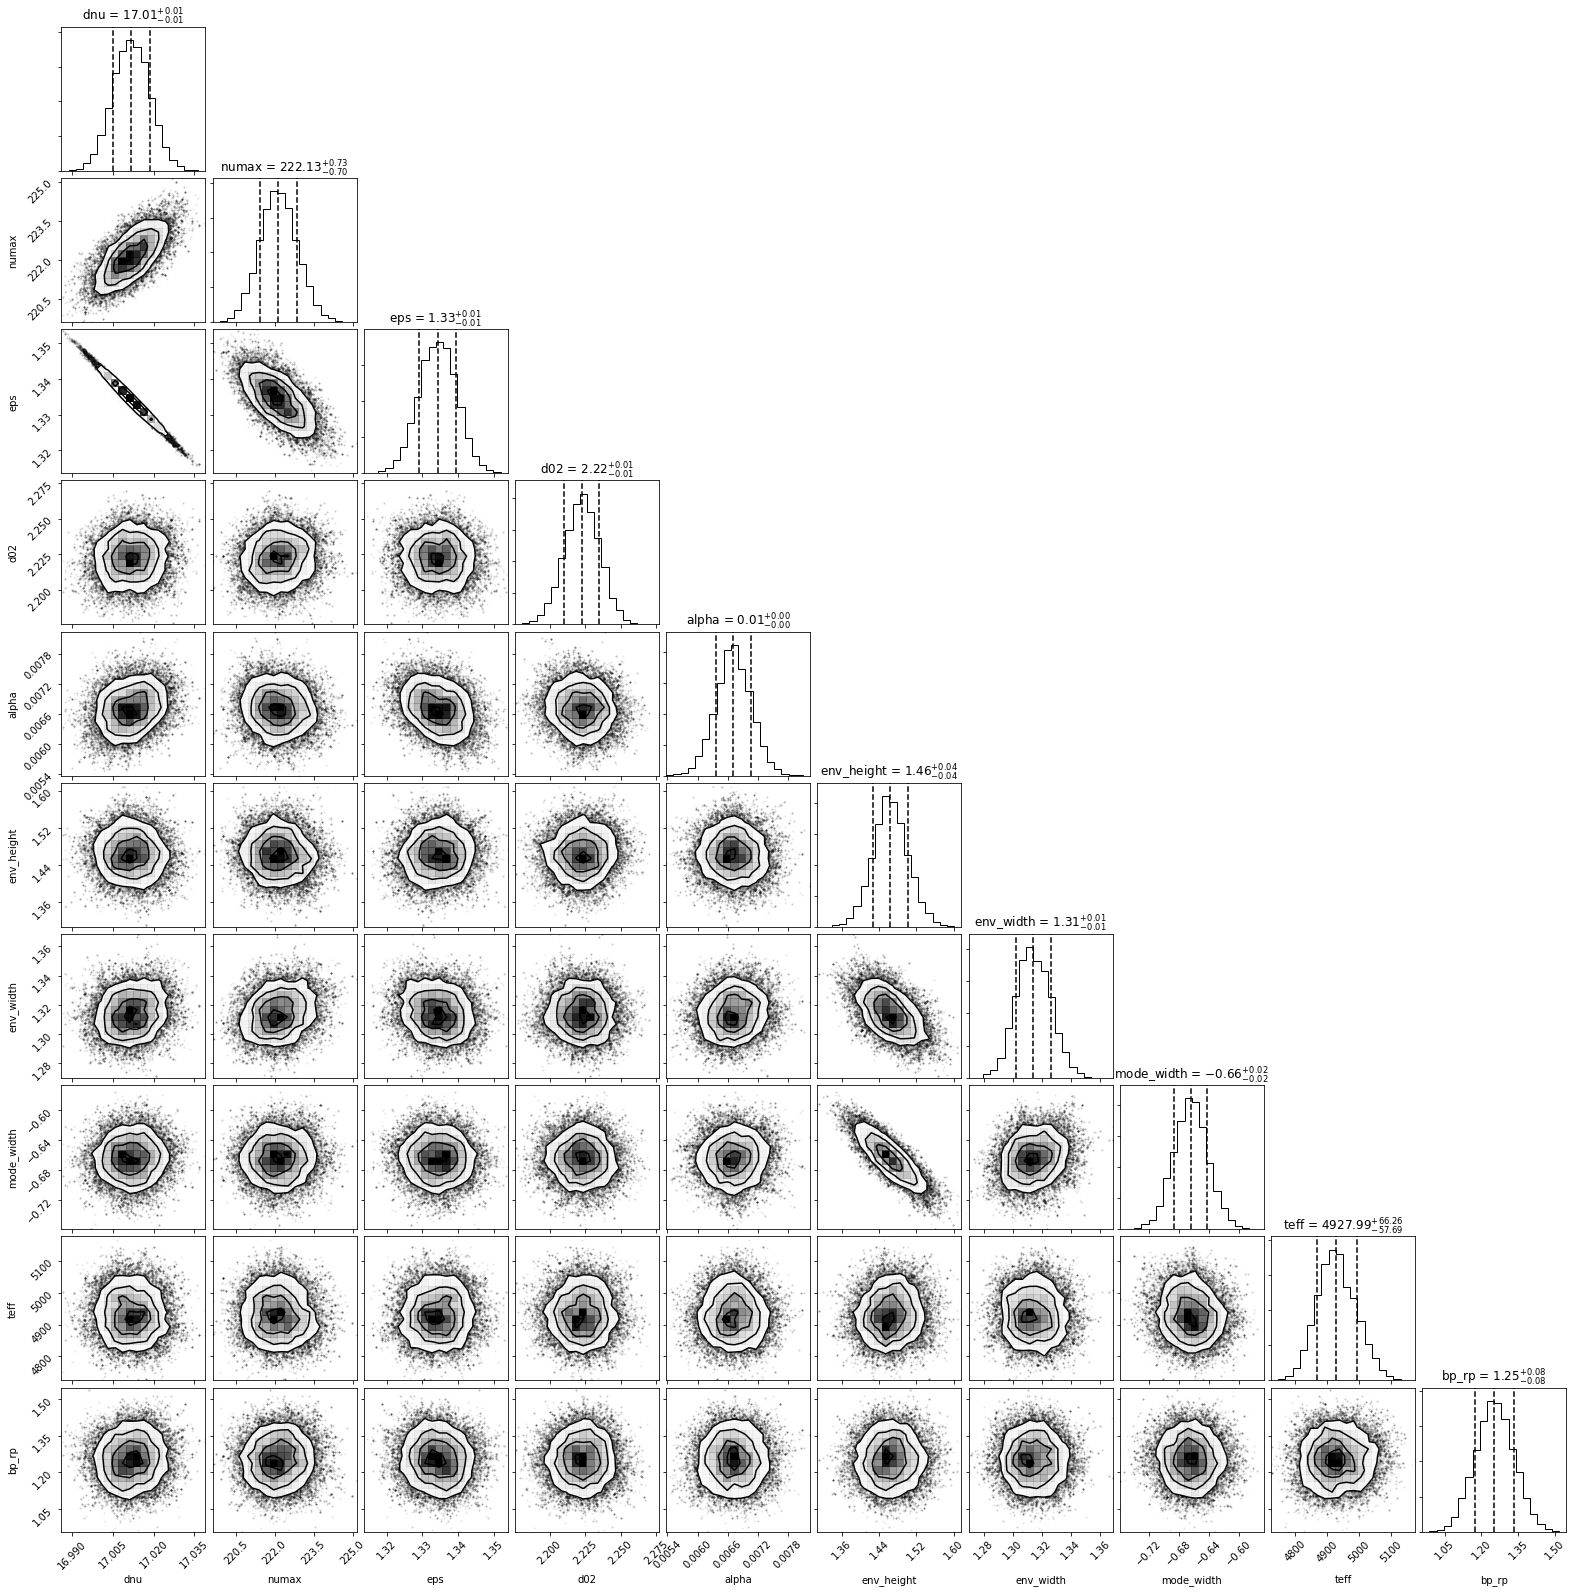

In [8]:
st.asy_fit.plot_corner();

This plot shows all the parameters that [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html) uses. The main parameters of interest are $\nu_{max}$, $\Delta \nu$, and $\epsilon$.  The remaining are less important, but may provide clues if something goes wrong during the fit. 

**Note** The $T_{\mathrm{eff}}$ and $B_p-R_p$ differ from the initial guesses. In this case the true value of $B_p-R_p$ is 1.23 [(Gaia Collaboration et al. 2018)](http://vizier.u-strasbg.fr/viz-bin/VizieR-S?Gaia%20DR2%202100458330254478464). 

We can plot a sub-set of the best-fitting models on top of the spectrum:

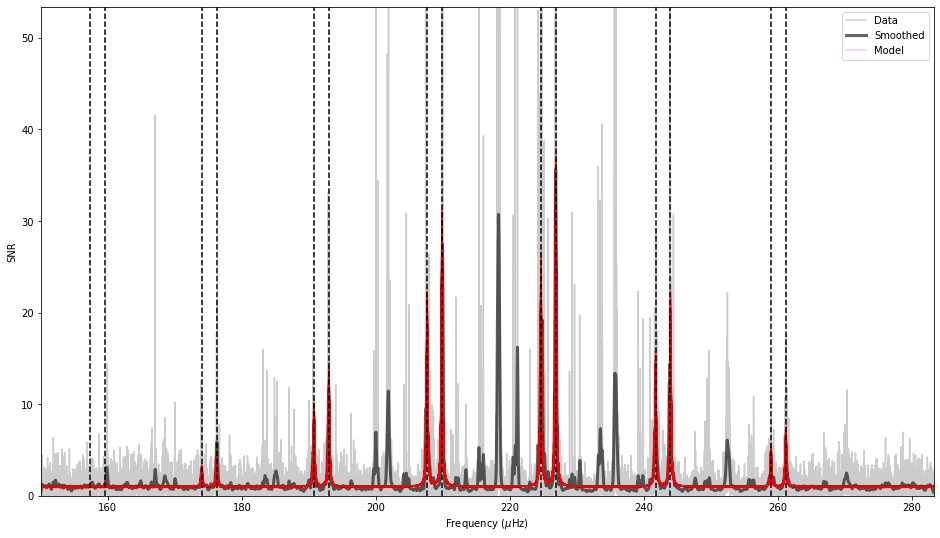

In [9]:
st.asy_fit.plot();

Now we have a bit better view of what the initial guess for the last peakbagging step will be, and you can see it already looks pretty good. To first order, [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html) is probably good enough to get a reasonable estimate of the mode frequencies. However, second order effects like acoustic glitches ([citation needed]()) are not currently incorporated into [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html). Furthermore, the above result is also strongly influenced by the prior, and the hight ratio between the $l=2$ and $l=0$ which is fixed to $0.7$. 

This is why we have the final peakbagging step, where we allow the mode frequencies to move freely and using less informative priors on the mode heights and widths.

We'll start the peakbagging by initiallizing the peakbagging using the results from [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html).

In [10]:
st.peakbag = pb.peakbag(star.f, star.s, star.asy_result)

We can check the starting location of the parameters by the resulting model:

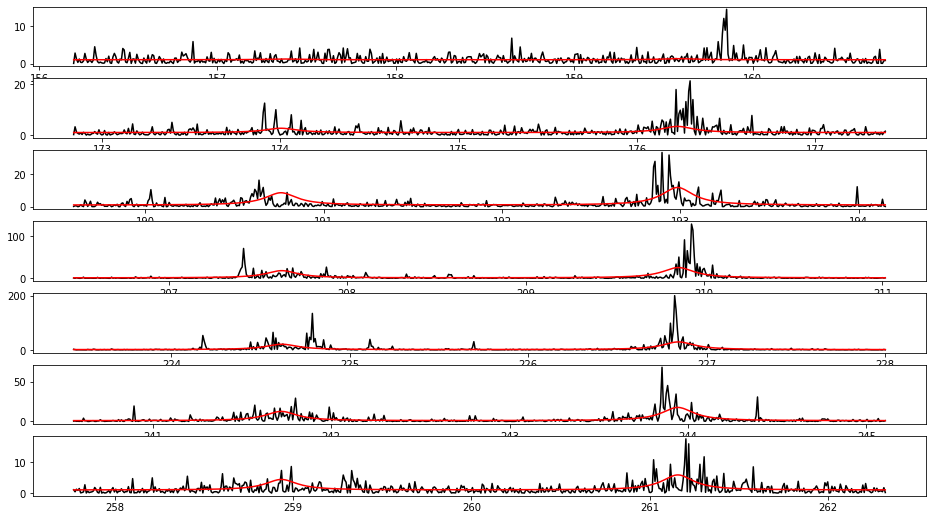

In [11]:
st.peakbag.plot_start_model();

Here this is shown in a ladder plot, with zoomed in windows on the $l=2,0$ pairs that are considered in the fit. Apart from the very first radial order, the initial guess looks reasonable. 

Now we can initiate the peakbagging run!

**Note:** This should be substantially faster than the [asy_peakbag](https://pbjam.readthedocs.io/en/latest/asy_peakbag.html) step, since we are not evaluating the KDE and can therefore use the more efficient HMC sampler from [pymc3](https://docs.pymc.io/). 

In [12]:
st.run_peakbag()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [back, height2, height0, width2, width0, l2, l0]
Sampling 4 chains: 100%|██████████| 8000/8000 [01:27<00:00, 51.65draws/s] 


This step will likely produce a tremendous amount of diagnostics on the fit, but essentially what it does is run the sampler for a few thousand steps, check for convergence, and then run some more if it's not satisfied with the result.

The result can be shown in a similar fashion as the initial guess

In [15]:
star.peakbag.plot_flat_fit(thin=10);

AttributeError: 'star' object has no attribute 'peakbag'

emcee: Exception while calling your likelihood function:
  params: [ 1.70136227e+01  2.22259593e+02  1.33252592e+00  2.21942453e+00
  6.91790535e-03  1.47598667e+00  1.32255651e+00 -6.79914652e-01
  4.92301911e+03  1.28297655e+00]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/emcee/ensemble.py", line 519, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/Users/davies/Code/PBjam/pbjam/asy_peakbag.py", line 849, in likelihood
    mod = self.model(p)
  File "/Users/davies/Code/PBjam/pbjam/asy_peakbag.py", line 349, in __call__
    return self.model(*p)
  File "/Users/davies/Code/PBjam/pbjam/asy_peakbag.py", line 332, in model
    mod += self.pair(f0s[n], Hs[n], modewidth, d02)
  File "/Users/davies/Code/PBjam/pbjam/asy_peakbag.py", line 283, in pair
    pair_model += self.lor(freq0 - d02, h*hfac, w)
  File "/Users/davies/Code/PBjam/pbjam/asy_peakbag.py", line 253, in lor
    return h / (1.0 + 4.0/w**2*(self.f - freq)**2)
KeyboardInterrupt


KeyboardInterrupt: 

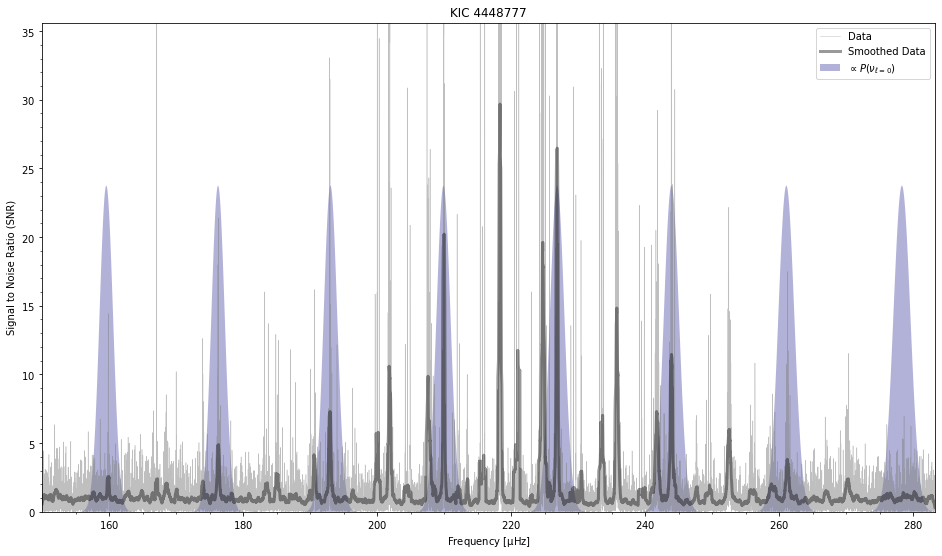

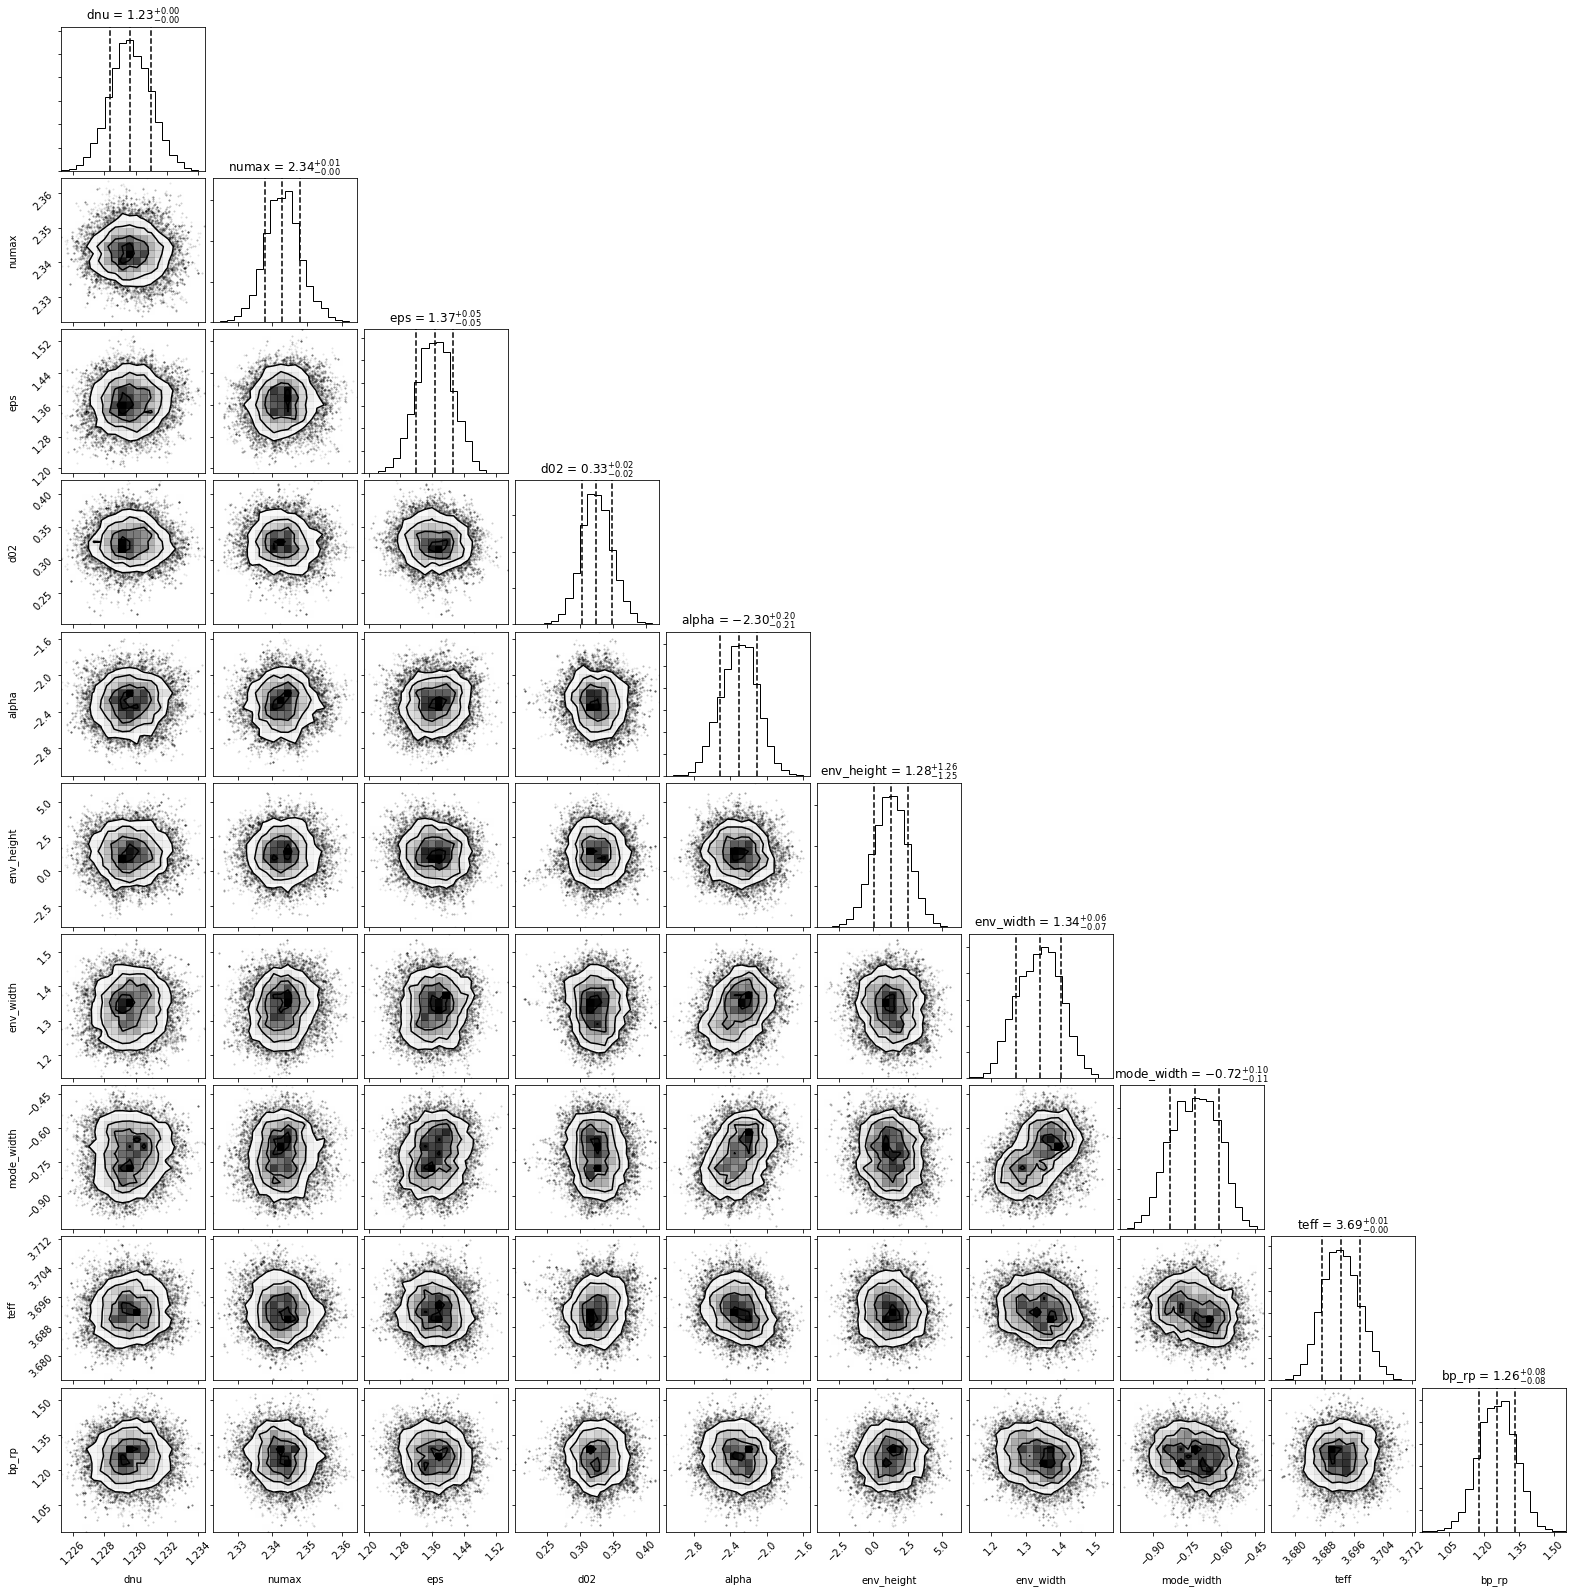

In [14]:
st.peakbag.plot_fit(thin=10);

The sample of models drawn from the posterior all appear to agree on where the modes are and their amplitudes seem to be reasonable. The resulting summary dataframe from [pymc3.stats.summary](https://docs.pymc.io/api/stats.html#pymc3.stats.summary) is written to the fit directory.

## Would you like to know more?
Read the API for the [star](https://pbjam.readthedocs.io/en/latest/star.html#pbjam.star.star) class and check out the [other tutorials](https://pbjam.readthedocs.io/en/latest/usage.html).